# AG News - Model Training Pipeline

**Task**: Single-label News Topic Classification  
**Models**: BERT-base, DistilBERT, TinyBERT  
**Framework**: HuggingFace Transformers + PyTorch  

---

## Pipeline Overview

1. Environment Setup
2. Load Processed Data
3. Model Configuration
4. Training Infrastructure
5. Fine-tune BERT-base (Baseline)
6. Fine-tune DistilBERT (Compressed)
7. Fine-tune TinyBERT (Efficient)
8. Save Models & Training Logs

## 1. Environment Setup

In [1]:
!pip install -q transformers datasets accelerate evaluate scikit-learn
!pip install -q matplotlib seaborn pandas numpy

In [2]:
import torch

if torch.cuda.is_available():
    print(f"✅ GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    device = torch.device('cuda')
else:
    print("⚠️ No GPU available, using CPU (training will be slow)")
    device = torch.device('cpu')

print(f"\nUsing device: {device}")

✅ GPU Available: Tesla T4
   Memory: 15.8 GB

Using device: cuda


In [3]:
import os
import json
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from datasets import load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    get_linear_schedule_with_warmup
)
import evaluate

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')

print("✅ All imports successful!")

✅ All imports successful!


## 2. Load Processed Data

In [4]:
import torch

if torch.cuda.is_available():
    print("🧹 Clearing CUDA cache and resetting GPU state...")
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    print("✅ GPU state cleared!")
else:
    print("ℹ️ No GPU available, skipping cache clear")

🧹 Clearing CUDA cache and resetting GPU state...
✅ GPU state cleared!


In [5]:
class TrainingConfig:
    DATA_DIR = './processed_data'
    MODEL_DIR = './models'
    LOG_DIR = './logs'
    
    MODEL_CHECKPOINTS = {
        'bert-base': 'bert-base-uncased',
        'distilbert': 'distilbert-base-uncased',
        'tinybert': 'huawei-noah/TinyBERT_General_4L_312D'
    }
    
    BATCH_SIZE = 16
    GRADIENT_ACCUMULATION_STEPS = 2
    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 3
    WARMUP_RATIO = 0.1
    WEIGHT_DECAY = 0.01
    
    EVAL_STRATEGY = 'epoch'
    SAVE_STRATEGY = 'epoch'
    LOAD_BEST_MODEL_AT_END = True
    METRIC_FOR_BEST_MODEL = 'accuracy'
    
    EARLY_STOPPING_PATIENCE = 2
    
    FP16 = torch.cuda.is_available()
    
    LABEL_NAMES = ['World', 'Sports', 'Business', 'Sci/Tech']
    NUM_LABELS = 4
    
    SEED = 42

config = TrainingConfig()

os.makedirs(config.MODEL_DIR, exist_ok=True)
os.makedirs(config.LOG_DIR, exist_ok=True)

torch.manual_seed(config.SEED)
np.random.seed(config.SEED)

print("📋 Training Configuration:")
print(f"   Batch Size: {config.BATCH_SIZE}")
print(f"   Gradient Accumulation: {config.GRADIENT_ACCUMULATION_STEPS}")
print(f"   Effective Batch Size: {config.BATCH_SIZE * config.GRADIENT_ACCUMULATION_STEPS}")
print(f"   Learning Rate: {config.LEARNING_RATE}")
print(f"   Epochs: {config.NUM_EPOCHS}")
print(f"   FP16: {config.FP16}")

📋 Training Configuration:
   Batch Size: 16
   Gradient Accumulation: 2
   Effective Batch Size: 32
   Learning Rate: 2e-05
   Epochs: 3
   FP16: True


In [6]:
print("📥 Loading processed dataset...")

dataset_path = os.path.join(config.DATA_DIR, 'ag_news_tokenized')
dataset = load_from_disk(dataset_path)

print(f"\n✅ Dataset loaded!")
print(dataset)

config_path = os.path.join(config.DATA_DIR, 'ag_news_config.json')
with open(config_path, 'r') as f:
    data_config = json.load(f)

print(f"\n📋 Data Configuration:")
print(f"   Max Length: {data_config['max_length']}")
print(f"   Train Size: {data_config['train_size']:,}")
print(f"   Validation Size: {data_config['val_size']:,}")
print(f"   Test Size: {data_config['test_size']:,}")

📥 Loading processed dataset...

✅ Dataset loaded!
DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'description', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 108000
    })
    validation: Dataset({
        features: ['label', 'title', 'description', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['label', 'title', 'description', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7600
    })
})

📋 Data Configuration:
   Max Length: 128
   Train Size: 108,000
   Validation Size: 12,000
   Test Size: 7,600

✅ Dataset loaded!
DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'description', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 108000
    })
    validation: Dataset({
        features: ['label', 'title', 'description', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12000
    })
    test

In [7]:
print("🔍 Verifying label range in processed dataset...")

for split_name in ['train', 'validation', 'test']:
    labels = dataset[split_name]['label']
    min_label = min(labels)
    max_label = max(labels)
    unique_labels = set(labels)
    
    print(f"\n{split_name.capitalize()} Split:")
    print(f"   Min Label: {min_label}")
    print(f"   Max Label: {max_label}")
    print(f"   Unique Labels: {sorted(unique_labels)}")
    
    if min_label == 0 and max_label == 3 and len(unique_labels) == 4:
        print(f"   ✅ Labels are correctly 0-indexed!")
    else:
        print(f"   ⚠️ WARNING: Labels are NOT in expected range [0, 3]")
        print(f"   You need to re-run the data preparation notebook from cell 17 onwards!")

print("\n" + "="*60)
print("⚠️ IMPORTANT: If labels are not 0-indexed above:")
print("   1. Go back to 01_data_preparation.ipynb")
print("   2. Re-run from cell 17 (preprocessing) onwards")
print("   3. Then come back to this training notebook")
print("="*60)

🔍 Verifying label range in processed dataset...

Train Split:
   Min Label: 0
   Max Label: 3

Train Split:
   Min Label: 0
   Max Label: 3
   Unique Labels: [tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tenso

## 3. Model Configuration & Metrics

In [8]:
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')
precision_metric = evaluate.load('precision')
recall_metric = evaluate.load('recall')

def compute_metrics(eval_pred):
    """
    Compute metrics for evaluation.
    
    Args:
        eval_pred: tuple of (predictions, labels)
    
    Returns:
        dict: computed metrics
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1_macro = f1_metric.compute(predictions=predictions, references=labels, average='macro')
    f1_weighted = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
    precision = precision_metric.compute(predictions=predictions, references=labels, average='macro')
    recall = recall_metric.compute(predictions=predictions, references=labels, average='macro')
    
    return {
        'accuracy': accuracy['accuracy'],
        'f1_macro': f1_macro['f1'],
        'f1_weighted': f1_weighted['f1'],
        'precision': precision['precision'],
        'recall': recall['recall']
    }

print("✅ Metrics configured!")

✅ Metrics configured!


In [9]:
def get_model_info(model):
    """
    Get model information including parameter count and size.
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    size_mb = (param_size + buffer_size) / 1024 / 1024
    
    return {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'size_mb': size_mb
    }

def print_model_info(model, model_name):
    """Print formatted model information."""
    info = get_model_info(model)
    print(f"\n📊 {model_name} Model Information:")
    print(f"   Total Parameters: {info['total_params']:,}")
    print(f"   Trainable Parameters: {info['trainable_params']:,}")
    print(f"   Model Size: {info['size_mb']:.1f} MB")
    return info

## 4. Training Infrastructure

In [10]:
def create_trainer(model, tokenizer, model_name, train_dataset, eval_dataset):
    """
    Create a HuggingFace Trainer with optimized settings for Colab.
    
    Args:
        model: The model to train
        tokenizer: The tokenizer
        model_name: Name for logging/saving
        train_dataset: Training dataset
        eval_dataset: Evaluation dataset
    
    Returns:
        Trainer: Configured trainer object
    """
    
    output_dir = os.path.join(config.MODEL_DIR, model_name)
    logging_dir = os.path.join(config.LOG_DIR, model_name)
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        
        num_train_epochs=config.NUM_EPOCHS,
        per_device_train_batch_size=config.BATCH_SIZE,
        per_device_eval_batch_size=config.BATCH_SIZE * 2,
        gradient_accumulation_steps=config.GRADIENT_ACCUMULATION_STEPS,
        
        learning_rate=config.LEARNING_RATE,
        weight_decay=config.WEIGHT_DECAY,
        warmup_ratio=config.WARMUP_RATIO,
        
        eval_strategy=config.EVAL_STRATEGY,
        save_strategy=config.SAVE_STRATEGY,
        load_best_model_at_end=config.LOAD_BEST_MODEL_AT_END,
        metric_for_best_model=config.METRIC_FOR_BEST_MODEL,
        greater_is_better=True,
        save_total_limit=2,
        
        logging_dir=logging_dir,
        logging_strategy='steps',
        logging_steps=100,
        report_to='none',
        
        fp16=config.FP16,
        dataloader_num_workers=2,
        
        seed=config.SEED,
        
        disable_tqdm=False,
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=config.EARLY_STOPPING_PATIENCE)]
    )
    
    return trainer

print("✅ Training infrastructure ready!")

✅ Training infrastructure ready!


In [11]:
def train_and_evaluate(model_key, model_checkpoint):
    """
    Complete training pipeline for a single model.
    
    Args:
        model_key: Short name for the model (e.g., 'bert-base')
        model_checkpoint: HuggingFace model checkpoint
    
    Returns:
        dict: Training results and metrics
    """
    print(f"\n{'='*60}")
    print(f"🚀 Training {model_key.upper()}")
    print(f"   Checkpoint: {model_checkpoint}")
    print(f"{'='*60}")
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    print(f"\n📦 Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    
    print(f"📦 Loading model...")
    model = AutoModelForSequenceClassification.from_pretrained(
        model_checkpoint,
        num_labels=config.NUM_LABELS,
        id2label={i: label for i, label in enumerate(config.LABEL_NAMES)},
        label2id={label: i for i, label in enumerate(config.LABEL_NAMES)}
    )
    
    model_info = print_model_info(model, model_key)
    
    print(f"\n⚙️ Creating trainer...")
    trainer = create_trainer(
        model=model,
        tokenizer=tokenizer,
        model_name=f"ag_news_{model_key}",
        train_dataset=dataset['train'],
        eval_dataset=dataset['validation']
    )
    
    print(f"\n🏋️ Starting training...")
    start_time = time.time()
    
    train_result = trainer.train()
    
    training_time = time.time() - start_time
    print(f"\n✅ Training complete! Time: {training_time/60:.1f} minutes")
    
    print(f"\n📊 Evaluating on validation set...")
    val_metrics = trainer.evaluate()
    
    print(f"\n📊 Evaluating on test set...")
    test_metrics = trainer.evaluate(dataset['test'])
    
    save_path = os.path.join(config.MODEL_DIR, f"ag_news_{model_key}_best")
    trainer.save_model(save_path)
    tokenizer.save_pretrained(save_path)
    print(f"\n💾 Model saved to: {save_path}")
    
    results = {
        'model_key': model_key,
        'model_checkpoint': model_checkpoint,
        'model_info': model_info,
        'training_time_minutes': training_time / 60,
        'train_metrics': train_result.metrics,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics
    }
    
    print(f"\n📋 {model_key.upper()} Results Summary:")
    print(f"   Validation Accuracy: {val_metrics['eval_accuracy']:.4f}")
    print(f"   Test Accuracy: {test_metrics['eval_accuracy']:.4f}")
    print(f"   Test F1 (Macro): {test_metrics['eval_f1_macro']:.4f}")
    
    del model, trainer
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return results

## 5. Fine-tune BERT-base (Baseline)

In [12]:
bert_results = train_and_evaluate(
    model_key='bert-base',
    model_checkpoint=config.MODEL_CHECKPOINTS['bert-base']
)


🚀 Training BERT-BASE
   Checkpoint: bert-base-uncased

📦 Loading tokenizer...
📦 Loading model...
📦 Loading model...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 bert-base Model Information:
   Total Parameters: 109,485,316
   Trainable Parameters: 109,485,316
   Model Size: 417.7 MB

⚙️ Creating trainer...

🏋️ Starting training...

🏋️ Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision,Recall
1,0.199400,0.204790,0.931667,0.931705,0.931705,0.932332,0.931667
2,0.121600,0.191994,0.940167,0.940207,0.940207,0.940946,0.940167
3,0.102100,0.206234,0.939833,0.939907,0.939907,0.940249,0.939833



✅ Training complete! Time: 36.4 minutes

📊 Evaluating on validation set...



📊 Evaluating on test set...

💾 Model saved to: ./models/ag_news_bert-base_best

📋 BERT-BASE Results Summary:
   Validation Accuracy: 0.9402
   Test Accuracy: 0.9408
   Test F1 (Macro): 0.9408

💾 Model saved to: ./models/ag_news_bert-base_best

📋 BERT-BASE Results Summary:
   Validation Accuracy: 0.9402
   Test Accuracy: 0.9408
   Test F1 (Macro): 0.9408


## 6. Fine-tune DistilBERT (Compressed)

In [13]:
distilbert_results = train_and_evaluate(
    model_key='distilbert',
    model_checkpoint=config.MODEL_CHECKPOINTS['distilbert']
)


🚀 Training DISTILBERT
   Checkpoint: distilbert-base-uncased

📦 Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

📦 Loading model...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 distilbert Model Information:
   Total Parameters: 66,956,548
   Trainable Parameters: 66,956,548
   Model Size: 255.4 MB

⚙️ Creating trainer...

🏋️ Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision,Recall
1,0.208300,0.199634,0.933000,0.932954,0.932954,0.933650,0.933000
2,0.131400,0.200420,0.935500,0.935468,0.935468,0.937394,0.935500
3,0.111200,0.204129,0.940583,0.940644,0.940644,0.941007,0.940583



✅ Training complete! Time: 20.3 minutes

📊 Evaluating on validation set...



📊 Evaluating on test set...

💾 Model saved to: ./models/ag_news_distilbert_best

📋 DISTILBERT Results Summary:
   Validation Accuracy: 0.9406
   Test Accuracy: 0.9387
   Test F1 (Macro): 0.9387

💾 Model saved to: ./models/ag_news_distilbert_best

📋 DISTILBERT Results Summary:
   Validation Accuracy: 0.9406
   Test Accuracy: 0.9387
   Test F1 (Macro): 0.9387


## 7. Fine-tune TinyBERT (Efficient)

In [14]:
tinybert_results = train_and_evaluate(
    model_key='tinybert',
    model_checkpoint=config.MODEL_CHECKPOINTS['tinybert']
)


🚀 Training TINYBERT
   Checkpoint: huawei-noah/TinyBERT_General_4L_312D

📦 Loading tokenizer...


config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

📦 Loading model...


pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 tinybert Model Information:
   Total Parameters: 14,351,500
   Trainable Parameters: 14,351,500
   Model Size: 54.8 MB

⚙️ Creating trainer...

🏋️ Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision,Recall
1,0.283100,0.271011,0.908083,0.907962,0.907962,0.908207,0.908083
2,0.219900,0.244893,0.919000,0.918865,0.918865,0.920779,0.919000
3,0.207100,0.230723,0.923500,0.923367,0.923367,0.924132,0.923500


model.safetensors:   0%|          | 0.00/62.7M [00:00<?, ?B/s]


✅ Training complete! Time: 9.3 minutes

📊 Evaluating on validation set...



📊 Evaluating on test set...

💾 Model saved to: ./models/ag_news_tinybert_best

📋 TINYBERT Results Summary:
   Validation Accuracy: 0.9235
   Test Accuracy: 0.9242
   Test F1 (Macro): 0.9241

💾 Model saved to: ./models/ag_news_tinybert_best

📋 TINYBERT Results Summary:
   Validation Accuracy: 0.9235
   Test Accuracy: 0.9242
   Test F1 (Macro): 0.9241


## 8. Save Training Results & Comparison

In [15]:
all_results = {
    'bert-base': bert_results,
    'distilbert': distilbert_results,
    'tinybert': tinybert_results
}

results_path = os.path.join(config.LOG_DIR, 'training_results.json')

serializable_results = {}
for key, res in all_results.items():
    serializable_results[key] = {
        'model_checkpoint': res['model_checkpoint'],
        'total_params': res['model_info']['total_params'],
        'size_mb': res['model_info']['size_mb'],
        'training_time_minutes': res['training_time_minutes'],
        'val_accuracy': res['val_metrics']['eval_accuracy'],
        'test_accuracy': res['test_metrics']['eval_accuracy'],
        'test_f1_macro': res['test_metrics']['eval_f1_macro'],
        'test_f1_weighted': res['test_metrics']['eval_f1_weighted'],
        'test_precision': res['test_metrics']['eval_precision'],
        'test_recall': res['test_metrics']['eval_recall']
    }

with open(results_path, 'w') as f:
    json.dump(serializable_results, f, indent=2)

print(f"✅ Results saved to: {results_path}")

✅ Results saved to: ./logs/training_results.json


In [16]:
comparison_data = []
for model_name, results in all_results.items():
    comparison_data.append({
        'Model': model_name,
        'Parameters (M)': results['model_info']['total_params'] / 1e6,
        'Size (MB)': results['model_info']['size_mb'],
        'Training Time (min)': results['training_time_minutes'],
        'Val Accuracy': results['val_metrics']['eval_accuracy'],
        'Test Accuracy': results['test_metrics']['eval_accuracy'],
        'Test F1 (Macro)': results['test_metrics']['eval_f1_macro']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 Model Comparison:")
print(comparison_df.to_string(index=False))


📊 Model Comparison:
     Model  Parameters (M)  Size (MB)  Training Time (min)  Val Accuracy  Test Accuracy  Test F1 (Macro)
 bert-base      109.485316 417.661148            36.399488      0.940167       0.940789         0.940764
distilbert       66.956548 255.422867            20.295137      0.940583       0.938684         0.938674
  tinybert       14.351500  54.754440             9.318326      0.923500       0.924211         0.924070


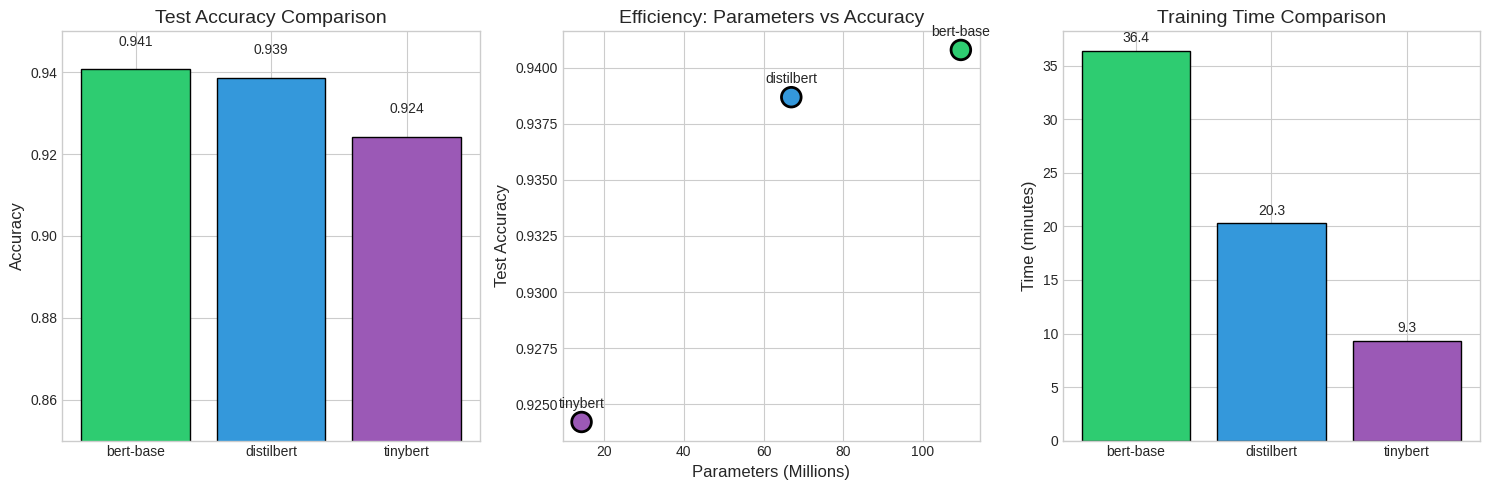


📊 Comparison plot saved to: ./logs/model_comparison.png


In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = comparison_df['Model'].tolist()
colors = ['#2ecc71', '#3498db', '#9b59b6']

bars1 = axes[0].bar(models, comparison_df['Test Accuracy'], color=colors, edgecolor='black')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Test Accuracy Comparison', fontsize=14)
axes[0].set_ylim(0.85, 0.95)
for bar, val in zip(bars1, comparison_df['Test Accuracy']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{val:.3f}', ha='center', va='bottom', fontsize=10)

axes[1].scatter(comparison_df['Parameters (M)'], comparison_df['Test Accuracy'],
               s=200, c=colors, edgecolor='black', linewidth=2)
for i, model in enumerate(models):
    axes[1].annotate(model, 
                    (comparison_df['Parameters (M)'].iloc[i], comparison_df['Test Accuracy'].iloc[i]),
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)
axes[1].set_xlabel('Parameters (Millions)', fontsize=12)
axes[1].set_ylabel('Test Accuracy', fontsize=12)
axes[1].set_title('Efficiency: Parameters vs Accuracy', fontsize=14)

bars3 = axes[2].bar(models, comparison_df['Training Time (min)'], color=colors, edgecolor='black')
axes[2].set_ylabel('Time (minutes)', fontsize=12)
axes[2].set_title('Training Time Comparison', fontsize=14)
for bar, val in zip(bars3, comparison_df['Training Time (min)']):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{val:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(config.LOG_DIR, 'model_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Comparison plot saved to: {os.path.join(config.LOG_DIR, 'model_comparison.png')}")